# Proyek Klasifikasi Gambar: Jenis Kucing
- **Nama:** Moch Ichwan Alif Kurniawan
- **Email:** ichwanalif55@gmail.com
- **ID Dicoding:** MC378D5Y1720

## Import Semua Packages/Library yang Digunakan

In [1]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm as tq

In [2]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [4]:
# !pip install tensorflowjs

In [4]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

#### Mengambil data dari Kaagle

In [1]:
# from google.colab import files
# files.upload()

In [2]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [3]:
# !kaggle datasets download -d mibrahimhanif/jenis-kucing
# !unzip jenis-kucing.zip

### Data Preprocessing

#### Plot Distribusi

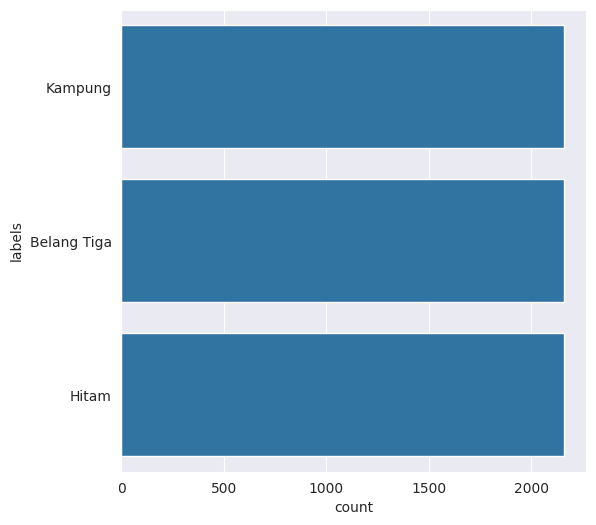

In [9]:
# Definisikan path sumber
cat_path = "train val"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(cat_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

#### Split Dataset

In [10]:
# Path ke dataset awal
dataset_path = "train val"
base_output_path = "split_dataset"

# Rasio split
train_split = 0.6
val_split = 0.2
test_split = 0.2

# Pastikan output folder ada
os.makedirs(base_output_path, exist_ok=True)

# Untuk setiap kelas
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        # List semua file gambar di folder kelas ini
        images = os.listdir(class_path)
        random.shuffle(images)

        n_total = len(images)
        n_train = int(n_total * train_split)
        n_val = int(n_total * val_split)

        # Split ke train/val/test
        train_files = images[:n_train]
        val_files = images[n_train:n_train+n_val]
        test_files = images[n_train+n_val:]

        # Copy file ke masing-masing folder
        for folder_name, file_list in zip(["train", "val", "test"], [train_files, val_files, test_files]):
            output_dir = os.path.join(base_output_path, folder_name, class_name)
            os.makedirs(output_dir, exist_ok=True)
            for file_name in file_list:
                src = os.path.join(class_path, file_name)
                dst = os.path.join(output_dir, file_name)
                shutil.copy2(src, dst)

print("Splitting selesai!")

Splitting selesai!


In [11]:
# ImageDataGenerator untuk training
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    'split_dataset/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# ImageDataGenerator untuk validation
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    'split_dataset/val',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# ImageDataGenerator untuk testing
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'split_dataset/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Untuk evaluasi akurasi lebih akurat
)

Found 3888 images belonging to 3 classes.
Found 1296 images belonging to 3 classes.
Found 1296 images belonging to 3 classes.


## Modelling

In [12]:
# Bangun model Sequential
model = Sequential([
    # CONVOLUTIONAL BLOCK 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # CONVOLUTIONAL BLOCK 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # CONVOLUTIONAL BLOCK 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten sebelum ke fully connected
    Flatten(),

    # Fully Connected Layer
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout untuk mengurangi overfitting

    # Output Layer
    Dense(train_generator.num_classes, activation='softmax')  # num_classes sesuai jumlah kelas kucing
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Lihat ringkasan arsitektur model
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,739 (18.42 MB)

 Trainable params: 4,828,739 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

#### Train model

In [13]:
# EarlyStopping: berhenti jika val_accuracy sudah lebih dari 95%
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,                  # Tunggu 5 epoch setelah stagnan
    mode='max',
    verbose=1,
    restore_best_weights=True,
    min_delta=0.001
)

# Training model
history = model.fit(
    train_generator,
    epochs=30,  # Target maksimal 30 epoch
    validation_data=val_generator,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 33s 218ms/step - accuracy: 0.5936 - loss: 0.8530 - val_accuracy: 0.7500 - val_loss: 0.5618
Epoch 2/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 21s 175ms/step - accuracy: 0.7310 - loss: 0.5586 - val_accuracy: 0.8194 - val_loss: 0.4597
Epoch 3/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step - accuracy: 0.8087 - loss: 0.4320 - val_accuracy: 0.7770 - val_loss: 0.4401
Epoch 4/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 21s 175ms/step - accuracy: 0.8555 - loss: 0.3480 - val_accuracy: 0.8866 - val_loss: 0.2810
Epoch 5/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 21s 175ms/step - accuracy: 0.9146 - loss: 0.2192 - val_accuracy: 0.8897 - val_loss: 0.2969
Epoch 6/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step - accuracy: 0.9214 - loss: 0.1995 - val_accuracy: 0.9329 - val_loss: 0.1941
Epoch 7/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.9582 - loss: 0.1120 - val_accuracy: 0.9298 - val_loss: 0.2292
Epoch 8/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 22s 179ms/step - accuracy: 0.9562 - loss: 0

## Evaluasi dan Visualisasi

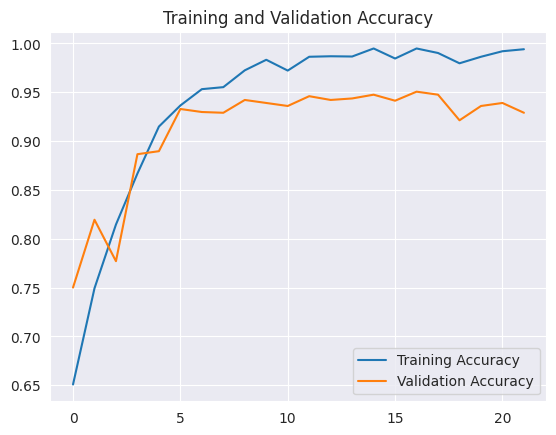

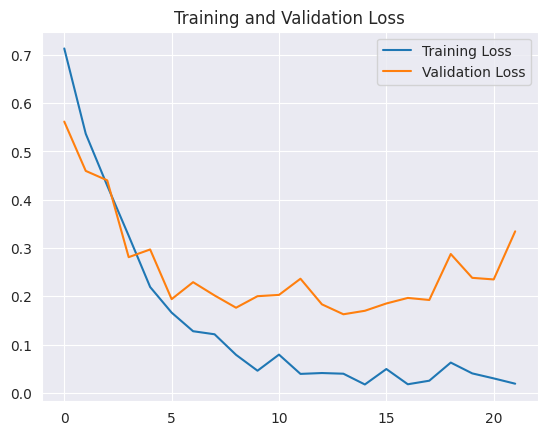

In [14]:
# Plot akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

## Konversi Model

In [15]:
# Buat direktori jika belum ada
os.makedirs('saved_model', exist_ok=True)
# Simpan model dalam format SavedModel
model.save('saved_model/jenis_kucing_model.h5')

In [16]:
# 1. Load model dari file .keras
model = tf.keras.models.load_model('saved_model/jenis_kucing_model.h5')

# 2. Build model (panggil sekali) pakai dummy input
dummy_input = tf.random.uniform([1, *model.input_shape[1:]])
model(dummy_input)

# 3. Buat dictionary signature untuk serving_default
@tf.function(input_signature=[tf.TensorSpec(shape=[None, *model.input_shape[1:]], dtype=tf.float32, name="inputs")])
def serving_fn(inputs):
    outputs = model(inputs)
    return {'outputs': outputs}

# 4. Export model ke SavedModel format (dengan serving_default)
tf.saved_model.save(
    model,
    export_dir="saved_model",
    signatures={"serving_default": serving_fn}
)

In [17]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model tfjs_model/

2025-05-01 09:34:21.733065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746092061.753979    7646 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746092061.760162    7646 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-01 09:34:25.636999: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1746092065.637152    7646 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [18]:
os.makedirs('tflite', exist_ok=True)

In [19]:
# koversi ke tfjs_lite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()
# Simpan ke file
with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

In [20]:
labels = ['Belang Tiga', 'Hitam', 'Kampung']
with open('tflite/label.txt', 'w') as f:
    for label in labels:
        f.write(label + '\n')

In [23]:
# Kompres folder menjadi zip
shutil.make_archive('tflite','zip','tflite')

'/content/tflite.zip'

## Inference (Optional)